<a href="https://colab.research.google.com/github/ecohydro/DroughtEDM/blob/master/growing_season_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This repository contains functions for generating the prediction skill across East Africa on the Administrative Level 1 Level and computing a pixelwise evaluation of prediction skill using EDM across Africa for a given environmental variable

- To do: 
    - look at sensitivity of ED on spatial scale and then adjust pixelwise analysis so that it is using the optimal ED for each pixel
    - what to do about gaps in time series 
    
    
    http://maps.elie.ucl.ac.be/CCI/viewer/download/ESACCI-LC-QuickUserGuide-LC-Maps_v2-0-7.pdf

In [1]:
from pyEDM import *
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio
import xarray as xr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import fiona
import rasterio.mask
from descartes import PolygonPatch
from rasterio.plot import show
from tqdm import tqdm
import datetime
import random

In [2]:
croplands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Croplands/'
grasslands_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Grasslands/'
savannas_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_Savannas/'
cropnatveg_vars_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover2016/Variables_CropNatVeg/'
EA_TS_DIR = '/home/rgreen/DroughtEDM/Data/EA_TS/Final/'

Africa_simplex = '/home/rgreen/DroughtEDM/Data/Africa_simplex/' #out directory

Admin_boundaries = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/AdminBoundaries/'

In [3]:
precip_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Compressed/' #[0:522]
temp_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Compressed/'
ndvi_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Compressed/' #[0:522]

precip_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/EA/'
temp_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/EA/'
ndvi_ea = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/EA/'

In [4]:
precip_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/CHIRPS/Anomaly/'
temp_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/LST/Anomaly/'
ndvi_anom_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/eMODIS_NDVI/Anomaly/'

In [143]:
broadleaf_open_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_broadleaf_open/'
crop_irr_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_irr/'
crop_rain_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_crop_rain/'
grassland_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_grassland/'
shrubland_dir = '/home/rgreen/tana-spin/rgreen/DroughtEDM/Data/VariablesByLandCover16/variables_shrubland/'

In [6]:
ea_adminbds = Admin_boundaries + 'gadm36_EastAfrica.shp'
ea_bndry = gpd.read_file(ea_adminbds)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
Africa_basemap = world[world['continent'] == 'Africa']
EA_countries = ['Burundi', 'Djibouti', 'Eritrea', 'Ethiopia', 'Kenya', 'Rwanda', 'Sudan', 'S. Sudan', 'Somalia', 'Somaliland', 'South Sudan', 'Tanzania', 'Uganda']
EastAfrica_basemap = world[world['name'].isin(EA_countries)]
EastAfrica_basemap.to_file(Admin_boundaries + 'EastAfrica_countries.shp')

In [167]:
begin = pd.datetime(2002,7,1)
end = pd.datetime(2019,4,30)
dtrange = pd.date_range(begin, end)
days = list(range(len(dtrange))) #length of dtrange
daysDF = pd.DataFrame({'Days': days}, index=dtrange)
d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
dekads = daysDF.groupby(dekaddates).mean()
dekads = dekads.index

In [169]:
dekads

DatetimeIndex(['2002-07-01', '2002-07-11', '2002-07-21', '2002-08-01',
               '2002-08-11', '2002-08-21', '2002-09-01', '2002-09-11',
               '2002-09-21', '2002-10-01',
               ...
               '2019-01-21', '2019-02-01', '2019-02-11', '2019-02-21',
               '2019-03-01', '2019-03-11', '2019-03-21', '2019-04-01',
               '2019-04-11', '2019-04-21'],
              dtype='datetime64[ns]', length=606, freq=None)

## 2. Generate Anomaly Rasters to remove Climatology

In [8]:
def stack_rasters(in_dir, keyword):
    
    '''
    This function creates a raster stack xarray DataArray given a specified variable keyword.
    Keywords = 'precip', 'ndvi','lst'
    
    '''
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains('.tif')
    files = files[tifs]
    
    stacked = []
    
    for filename in tqdm(files): 
        if keyword in filename:
    
            file = xr.open_rasterio(in_dir+filename)
            stacked.append(file.sel(band=1))
            
    combined = xr.concat(stacked, dim = 'time')
  

    return combined.assign_coords(time=dekads)

In [276]:
#stack_out = stack_rasters(precip_dir, 'chirps')

stack_out = stack_rasters(ndvi_ea, 'ndvi')

100%|██████████| 606/606 [00:03<00:00, 159.43it/s]


In [279]:
#use this just for NDVI

ds_ndvi = (stack_out-100)/100
ds_anom = ds_ndvi.groupby('time.month') - ds_ndvi.groupby('time.month').mean('time')

#all other variables
#ds_anom = stack_out.groupby('time.month') - stack_out.groupby("time.month").mean("time")

/home/rgreen/miniconda3/envs/edm/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [280]:
def dataarray2tiff(dataarray, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D xarray DataArray into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile
        
    for i in np.arange(0,len(os.listdir(in_dir))):
        data = np.array(dataarray[i])
       
        with rasterio.open(out_dir + out_name + str(np.array(dataarray[i].time))[:10] + '.tif', 'w', **profile) as dst:
            
            data = data.astype(np.float32)
            dst.write(data, indexes = 1)

In [ ]:
dataarray2tiff(ds_anom, ndvi_ea, ndvi_anom_dir, 'anom_ea_ndvi_')

## 3. Pixelwise Prediction Skill Across Africa

In [147]:
def pixelwise_ts_table(in_dir, keyword):
    
    '''
    This function searches through the file directory and creates a dataframe of pixel values over time from rasters
    based on a given keyword describing the environmental variable of interest to generate a raster time series stack 
    
   In the output dataframe, columns are each pixel extracted from the raster (read squentially into a list)
   and rows are the same pixel over time (dekads going down)
    
    Args:
    - in_dir: path to the input directory
    -keyword: string that is unique to the environmental variable
        options: ['chirps', 'lst', 'ndvi', 'pet', 'SM', 'Tmax']
    '''
    
    
    files=np.array(sorted(os.listdir(in_dir)))
    tifs = pd.Series(files).str.contains(keyword)
    files = files[tifs]
    #n_samples = len(files)
    
    
    pixelwise_TS = []
    
    for filename in tqdm(files): 
        
        open_file = xr.open_rasterio(in_dir+filename).sel(band=1)
        array = open_file.values

        # Determine the size of the datatable
        #rs_cols, rs_rows = array.shape()
        
#         rs_cols = array.shape[0]
#         rs_rows = array.shape[1]

        pixel_list = array.ravel().tolist()
   
        pixelwise_TS.append(pixel_list)

        # Create a DataFrame from the pixelwise list:
       # table = pd.DataFrame(pixelwise_TS)

        # Add rs_cols and rs_rows as attributes to the table DataFrame
#         table.rs_cols = rs_cols
#         table.rs_rows = rs_rows
#         table.n_samples = n_samples
#         if label:
#             table.label = label
    return pd.DataFrame(pixelwise_TS)

    

In [98]:
precip_table = pixelwise_ts_table(precip_ea)
temp_table = pixelwise_ts_table(temp_ea)
ndvi_table = pixelwise_ts_table(ndvi_ea)

100%|██████████| 606/606 [00:08<00:00, 72.17it/s]


In [114]:
# Need to fix the code in pixelwise_ts_table so that it runs fast and we don't need this stuff:
precip_table.label = 'precip'
precip_table.rs_rows = 674
precip_table.rs_cols = 583
precip_table.n_samples = 606
ndvi_table.label = 'ndvi'
ndvi_table.rs_rows = 674
ndvi_table.rs_cols = 583
ndvi_table.n_samples = 606
temp_table.label = 'temp'
temp_table.rs_rows = 674
temp_table.rs_cols = 583
temp_table.n_samples = 606

table_list = [precip_table, ndvi_table, temp_table]
# col = range(len(table_list[0].columns))[0]
# interim_df = extract_column(table_list, col)

In [149]:
# precip_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'precip')
# ndvi_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'ndvi')
# temp_broadleaf = pixelwise_ts_table(broadleaf_open_dir, 'temp')

100%|██████████| 606/606 [00:10<00:00, 60.59it/s]


In [151]:
# precip_broadleaf.label = 'precip'
# precip_broadleaf.rs_rows = 674
# precip_broadleaf.rs_cols = 583
# precip_broadleaf.n_samples = 606
# ndvi_broadleaf.label = 'ndvi'
# ndvi_broadleaf.rs_rows = 674
# ndvi_broadleaf.rs_cols = 583
# ndvi_broadleaf.n_samples = 606
# temp_broadleaf.label = 'temp'
# temp_broadleaf.rs_rows = 674
# temp_broadleaf.rs_cols = 583
# temp_broadleaf.n_samples = 606

# table_list_broadleaf = [precip_broadleaf, ndvi_broadleaf, temp_broadleaf]

In [215]:
#np.where(temp_table[233600].isnull())[0]
temp_table[233600].copy().fillna(temp_table[233600].mean())

False

In [ ]:

def multi_pixelwise_simplex(tables, target_label, train_dekads, test_dekads, ed, pi, n_skips=36):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: list of input tables, where every table has columns with the time series of each pixel in a raster
    - target_label: text label for the table to be used as the target (e.g. 'ndvi')
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
    '''
    begin = pd.datetime(2002,7,1)
    end = pd.datetime(2019,4,30)
    dtrange = pd.date_range(begin, end)
    days = list(range(len(dtrange))) #length of dtrange
    daysDF = pd.DataFrame({'Days': days}, index=dtrange)
    d = daysDF.index.day - np.clip((daysDF.index.day-1) // 10, 0, 2)*10 - 1 
    dekaddates = daysDF.index.values - np.array(d, dtype="timedelta64[D]")
    dekads = daysDF.groupby(dekaddates).mean()
    dekads = dekads.index
    
    table_dict = {
        'Time': list(range(0,tables[0].n_samples)) 
    }    
    simplex_out_df = []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels
    for col in tqdm(range(len(tables[0].columns))):
        [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(tables)]
        interim_df = pd.DataFrame(table_dict, index =- )
        print(interim_df)
        train_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in train_dekads])))
        train_season = interim_df.loc[train_list]
        
        test_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in test_dekads])))
        test_season = interim_df.loc[test_list]
        
        n_interim_df = pd.concat([train_season, test_season])
        n_interim_df.reset_index()
       # print(n_interim_df)
       
        if n_interim_df.isnull().values.any():
            simplex_out_df.append(np.nan)
            
        else:
#             
            simplex_result = Simplex(dataFrame = n_interim_df,
                                     lib = '1' + ' ' + str(len(train_season)),
                                     pred = str(len(train_season)+1) + ' ' + str(len(n_interim_df)),
                                     E = ed, Tp = pi,
                                     columns = labels, target = target_label, showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho)
            
            
    return(np.reshape(simplex_out_df, (tables[0].rs_rows, tables[0].rs_cols)))
            



In [246]:

def multi_pixelwise_simplex(tables, target_label, train_dekads, test_dekads, ed, pi, n_skips=36):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given multiple tables of different variables of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: list of input tables, where every table has columns with the time series of each pixel in a raster
    - target_label: text label for the table to be used as the target (e.g. 'ndvi')
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
    '''
    
    
    table_dict = {
        'Time': list(range(0,tables[0].n_samples)) 
    }    
    simplex_out_df = []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels
    for col in tqdm(range(233200,len(tables[0].columns))):
        [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(tables)]
        #interim_df = pd.DataFrame(table_dict, index = dekads)
        interim_df = pd.DataFrame(table_dict)
        #print(interim_df)
        train_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in train_dekads])))
        train_season = interim_df.loc[train_list]
        
        test_list = sorted(list(np.concatenate([np.arange(dekad, tables[0].n_samples, n_skips) for dekad in test_dekads])))
        test_season = interim_df.loc[test_list]
        
        n_interim_df = pd.concat([train_season, test_season])
        n_interim_df.reset_index()
       # print(n_interim_df)
        
        
        #interim_df['MONTH'] = interim_df.index.month
        
        #interim_df.sort_values(by='MONTH')
        #interim_df.sort_values(by=interim_df.index.month, inplace=True)
        
        #m_test = [10,11,12]
        
        #dekads[:36:3][dekads[:36:3].month == m_test[0]]
        
        
        
        # lib = dekads[1] + ' ' + dekads[]
    
    
        
        for col in list(n_interim_df.columns):
            if n_interim_df[col].isnull().values.any():
                n_interim_df[col].fillna(n_interim_df[col].mean(), inplace=True)
                #simplex_out_df.append(np.nan)
        
        
        if n_interim_df.isnull().values.any():
            simplex_out_df.append(np.nan)
            
        else:
#             
#             simplex_result = Simplex(dataFrame = n_interim_df,
#                                      lib = '1' + ' ' + str(len(train_season)),
#                                      pred = str(len(train_season)+1) + ' ' + str(len(n_interim_df)),
#                                      E = ed, Tp = pi,
#                                      columns = labels, target = target_label, showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             rho = list(error.values())[2]
#             simplex_out_df.append(rho)
            
            simplex_result = Simplex(dataFrame = n_interim_df,
                                     lib = '1' + ' ' + str(len(train_season)),
                                     pred = str(len(train_season)+1) + ' ' + str(len(n_interim_df)),
                                     E = ed, Tp = pi,
                                     columns = labels, target = target_label, showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho)
            
    return simplex_out_df
    #return(np.reshape(simplex_out_df, (tables[0].rs_rows, tables[0].rs_cols)))
            



In [229]:
pre_ond_dekads = [0, 1, 2, 3, 4, 5, 6, 7, 8]
ond_dekads = [9, 10, 11, 12, 13, 14, 15, 16, 17]

pre_djf_dekads = [6, 7, 8, 9, 10, 11, 12, 13, 14]
djf_dekads=[15, 16, 17, 18, 19, 20, 21, 22, 23]

mam_dekads=[24, 25, 26, 27, 28, 29, 30, 31, 32]
jja_dekads = [33, 34, 35, 36, 37, 38, 39, 40, 41]

In [230]:
#broadleaf_ndvi_ea_simplex_multi_mam = multi_pixelwise_simplex(table_list_broadleaf, 'ndvi', train_dekads = djf_dekads, test_dekads = mam_dekads, ed = 2, pi = 18)

In [249]:
ndvi_ea_simplex_multi_mam = multi_pixelwise_simplex(table_list, 'ndvi', train_dekads = djf_dekads, test_dekads = mam_dekads, ed = 2, pi = 18)

100%|██████████| 159742/159742 [14:07<00:00, 188.52it/s]


In [254]:
159742/583

274.0

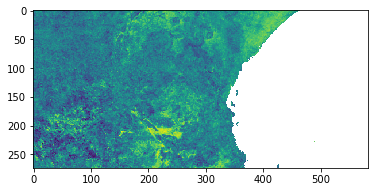

In [256]:
plt.imshow(np.reshape(ndvi_ea_simplex_multi_mam, (274, 583)))

TypeError: Invalid shape (159742,) for image data

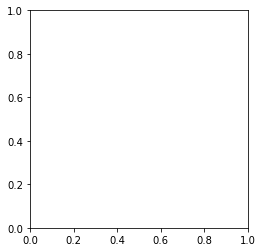

In [252]:
plt.imshow(ndvi_ea_simplex_multi_mam)

In [233]:
583*450 + 180

262530

In [237]:
np.where(temp_table[262530].isnull())[0]
temp_table[262530].copy().fillna(temp_table[262530].mean()).isnull().any()

False

In [86]:
ndvi_ea_simplex_multi_djf = multi_pixelwise_simplex(table_list, 'ndvi', train_dekads = pre_djf_dekads, test_dekads = djf_dekads, ed = 2, pi = 18)


100%|██████████| 392942/392942 [26:34<00:00, 246.49it/s]


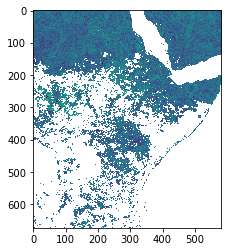

In [88]:
plt.imshow(ndvi_ea_simplex_multi_djf)

In [170]:
583*400 + 400

233600

In [89]:
ndvi_ea_simplex_multi_ond = multi_pixelwise_simplex(table_list, 'ndvi', train_dekads = pre_ond_dekads, test_dekads = ond_dekads, ed = 2, pi = 18)
# ndvi_ea_simplex1 = multi_pixelwise_simplex('1 100', '101 606', 2, 18, 674, 583)

100%|██████████| 392942/392942 [26:10<00:00, 250.25it/s]


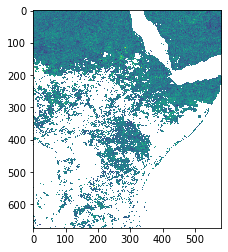

In [90]:
plt.imshow(ndvi_ea_simplex_multi_ond)

In [69]:
def pixelwise_simplex(tables, target_label, train, test, ed, pi):
    
    '''
    This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
    across pixels given a table of pixel values across time for a region from the function pixelwise_ts_table 

    The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
    Args:
    - table: input table, where every column is the time series of each pixel in a raster
    - train: portion of data library used to train (string of range with space between values)
    - test: portion of data libary used to test (string of range with space between values) 
    - ed: embedding dimension
    - pi: prediction interval (Tp) 
    - rs_rows: number of rows to reshape list into original raster size
    - rs_cols: number of columns to reshape list into original raster size
   
     '''

    simplex_out_df = []
    table_dict = {
        'Time': list(range(0,tables[0].n_samples)) 
    }    
    simplex_out_df = []
    labels = ' '.join([table.label for table in tables]) # Assumes that all tables have labels
    for col in tqdm(range(len(table_list[0].columns))):
        [table_dict.update({table.label: table.iloc[:,col]}) for i, table in enumerate(table_list)]
        interim_df = pd.DataFrame(table_dict)
    
        if interim_df.isnull().values.any():
            
            simplex_out_df.append(np.nan)
        else:
            
            #interim_df = pd.DataFrame({'Time': list(range(0,table.n_samples)), 'Data': table[column]}) #'Time': dekads
            simplex_result = Simplex(dataFrame = interim_df, 
                                     lib = train,
                                     pred = test,
                                     E = ed, Tp = pi, 
                                     columns = labels, target = target_label, showPlot = False)
            error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
            rho = list(error.values())[2]
            simplex_out_df.append(rho) 
            
    return(np.reshape(simplex_out_df, (table_list[0].rs_rows, table_list[0].rs_cols)))
            



In [70]:
ndvi_ea_simplex = pixelwise_simplex(table_list, 'ndvi', '1 100', '101 606', 2, 18)


#precip_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 1600, 1500) #1500, 1600

100%|██████████| 392942/392942 [19:40<00:00, 332.75it/s]


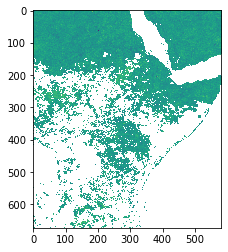

In [72]:
# fig = plt.figure()
plt.imshow(ndvi_ea_simplex)

In [ ]:
# ndvi_crops_africa_simplex = pixelwise_simplex(ndvi_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_crops_africa_simplex = pixelwise_simplex(temp_crops_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_crops_africa_simplex = pixelwise_simplex(precip_crops_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_grass_africa_simplex = pixelwise_simplex(ndvi_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_grass_africa_simplex = pixelwise_simplex(temp_grass_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_grass_africa_simplex = pixelwise_simplex(precip_grass_table, '1 100', '101 522', 2, 18, 800, 730)

# ndvi_sav_africa_simplex = pixelwise_simplex(ndvi_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# temp_sav_africa_simplex = pixelwise_simplex(temp_sav_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_sav_africa_simplex = pixelwise_simplex(precip_sav_table, '1 100', '101 522', 2, 18, 800, 730)

In [284]:
# def growing_pixelwise_simplex(table, ed, pi, train_dekads, test_dekads, n_skips=36): # d1,d2,d3,d4,d5,d6,d7,d8,d9],d10,d11,d12,d13,d14,d15,d16,d17,d18):# ,  train_start_date, train_end_date, test_start_date, test_end_date):
    
#     '''
#     This function computes the simplex prediction skill for a given embedding dimensions, prediction interval, land cover and environmental variable
#     across pixels given a table of pixel values across the time of growing season given the months leading up to the rains
#     for a region from the function pixelwise_ts_table 

#     The result is an np.array of simplex error values reshaped back into the shape of the original raster image
    
#     Args:
#     - table: input table from pixelwise_ts_table result of each pixel's time series
#     - train: portion of data library used to train (string of range with space between values)
#     - test: portion of data libary used to test (string of range with space between values) 
#     - ed: embedding dimension
#     - pi: prediction interval (Tp) 
#     - rs_rows: number of rows to reshape list into original raster size
#     - rs_cols: number of columns to reshape list into original raster size
#     - train_dekads: list of dekads to use in training
#     - test_dekads: list of dekads to use in testing
#     - n_skips: Number of skips between dekads (default is 36, which is 1 year)
   
#     '''

#     n_skips = 36
#     simplex_out_df = []
#     #table_chunk = table.loc[:100,500:510]
    
#     for column in tqdm(table):
#         #print(column)
#         if table[column].isnull().values.any():
#             #print('null')
#             simplex_out_df.append(np.nan)
#         else:
#             #do simplex function on these columns
#             #change dekads to just a time list
#             interim_df = pd.DataFrame({'Time': list(range(0,tables[0].n_samples)), 'Data': table[column]}) #'Time': dekads
#             train_list = sorted(list(np.concatenate([np.arange(dekad, table.n_samples, n_skips) for dekad in train_dekads])))
#             train_season = interim_df.loc[train_list]
#             train_season.reset_index()
#             #train_season = interim_df[(interim_df['Time'].dt.month >= train_start_date) & (interim_df['Time'].dt.month <= train_end_date)]
#             test_list = sorted(list(np.concatenate([np.arange(dekad, table.n_samples, n_skips) for deckad in test_dekads])))
#             test_season = interim_df.loc[test_list]
#             #test_season = interim_df[(interim_df['Time'].dt.month >= test_start_date) & (interim_df['Time'].dt.month <= test_end_date)]

#             test_season.reset_index()

            
#             simplex_result = Simplex(dataFrame = interim_df, lib = str(train_season.index[0]) + ' ' + str(train_season.index[-1]), pred = str(test_season.index[0]) + ' ' + str(test_season.index[-1]), E = ed, Tp = pi, columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
            
           
#             simplex_out_df.append(rho) #adjust measure depending on output interest
            
#     return(np.reshape(simplex_out_df, (table.rs_rows, table.rs_cols)))
            
            




In [ ]:
ond_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, 674, 583, train_decads=[9, 10, 11, 12, 13, 14, 15, 16, 17], test_decads=[18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

392942it [53:20, 122.79it/s]                      


In [288]:
train_decads=[15, 16, 17, 18, 19, 20, 21, 22, 23]
test_decads=[24, 25, 26, 27, 28, 29, 30, 31, 32]
djf_ndvi = growing_pixelwise_simplex(ndvi_table, 2, 18, train_decads, test_decads)

93992it [36:48, 42.57it/s]                       


KeyboardInterrupt: 

In [ ]:
#temp_africa_simplex = pixelwise_simplex(temp_table, '1 100', '101 522', 2, 18, 800, 730)
# precip_africa_simplex = pixelwise_simplex(precip_table, '1 100', '101 522', 2, 18, 800, 730)
# ndvi_africa_simplex = pixelwise_simplex(ndvi_table, '1 100', '101 522', 2, 18, 800, 730)

#sm_africa_simplex = pixelwise_simplex(sm_table, '1 100', '101 522', 2, 18, 800, 730)
#lst_africa_simplex = pixelwise_simplex(lst_table, '1 100', '101 522', 2, 18, 800, 730)
#pet_africa_simplex = pixelwise_simplex(pet_table, '1 100', '101 522', 2, 18, 800, 730)



584000it [01:22, 7039.39it/s]                      


convert array to raster to save out

In [389]:
def array2tiff(array, in_dir, out_dir, out_name):
    
    '''
    This function converts a 2D array into a tif using the profile of an existing tif

    '''
    

    with rasterio.open(in_dir+ os.listdir(in_dir)[0]) as src:
        profile = src.profile

    with rasterio.open(out_dir + out_name + '.tif', 'w', **profile) as dst:
        data = array
        data = data.astype(np.float32)
        #data[data<=0] = np.nan
        dst.write(data, indexes=1)
    


In [470]:
array2tiff(ndvi_ea_simplex_multi_ond, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_ond')
array2tiff(ndvi_ea_simplex_multi_djf, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi_djf')

In [391]:
# array2tiff(ndvi_ea_simplex1, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex')
#array2tiff(ndvi_ea_simplex1, ndvi_ea, Africa_simplex, 'ndvi_ea_simplex_multi')

In [ ]:
# array2tiff(temp_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'temp_africa_simplex_crop')
# array2tiff(precip_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'precip_africa_simplex_crop')
# array2tiff(ndvi_crops_africa_simplex, croplands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_crop')

# array2tiff(temp_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'temp_africa_simplex_grass')
# array2tiff(precip_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'precip_africa_simplex_grass')
# array2tiff(ndvi_grass_africa_simplex, grasslands_vars_dir, Africa_simplex, 'ndvi_africa_simplex_grass')

# array2tiff(temp_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'temp_africa_simplex_sav')
# array2tiff(precip_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'precip_africa_simplex_sav')
# array2tiff(ndvi_sav_africa_simplex, savannas_vars_dir, Africa_simplex, 'ndvi_africa_simplex_sav')

Plot

In [479]:
def mask_raster_shp(shp, raster, out_name, in_dir, out_dir):
    
    '''
    This function masks a raster to the shape of a smaller shapefile and creates a new raster
    
    '''
    with fiona.open(shp, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(in_dir + raster) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, nodata = 0, crop=True)
        out_meta = src.meta

    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

    with rasterio.open(out_dir + out_name, "w", **out_meta) as dest:
          
        dest.write(out_image)

In [480]:
mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi_ond.tif', 'ndvi_eastafrica_simplex_multi_ond.tif', Africa_simplex, Africa_simplex)
mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi_djf.tif', 'ndvi_eastafrica_simplex_multi_djf.tif', Africa_simplex, Africa_simplex)

In [ ]:
#mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_uni.tif', 'ndvi_eastafrica_simplex_uni.tif', Africa_simplex, Africa_simplex)

#mask_raster_shp(ea_adminbds, 'ndvi_ea_simplex_multi.tif', 'ndvi_eastafrica_simplex_multi.tif', Africa_simplex, Africa_simplex)

In [ ]:
# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_crop.tif', 'temp_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_crop.tif', 'precip_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_crop.tif', 'ndvi_eastafrica_simplex_crop.tif', Africa_simplex, Africa_simplex)

# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_grass.tif', 'temp_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_grass.tif', 'precip_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_grass.tif', 'ndvi_eastafrica_simplex_grass.tif', Africa_simplex, Africa_simplex)

# mask_raster_shp(ea_adminbds, 'temp_africa_simplex_sav.tif', 'temp_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'precip_africa_simplex_sav.tif', 'precip_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)
# mask_raster_shp(ea_adminbds, 'ndvi_africa_simplex_sav.tif', 'ndvi_eastafrica_simplex_sav.tif', Africa_simplex, Africa_simplex)



Plot East Africa Simplex

In [ ]:
# temp_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_crop.tif')
# precip_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_crop.tif')
# ndvi_eastafrica_simplex_crop_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_crop.tif')

# temp_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_grass.tif')
# precip_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_grass.tif')
# ndvi_eastafrica_simplex_grass_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_grass.tif')

# temp_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'temp_eastafrica_simplex_sav.tif')
# precip_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'precip_eastafrica_simplex_sav.tif')
# ndvi_eastafrica_simplex_sav_tif = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_sav.tif')

In [481]:
ndvi_eastafrica_simplex_multi_ond = rasterio.open(Africa_simplex + 'ndvi_eastafrica_simplex_multi_ond.tif')

In [483]:
ndvi_eastafrica_simplex_multi_ond.nodatavals

(None,)

[20, 55, -15, 25]

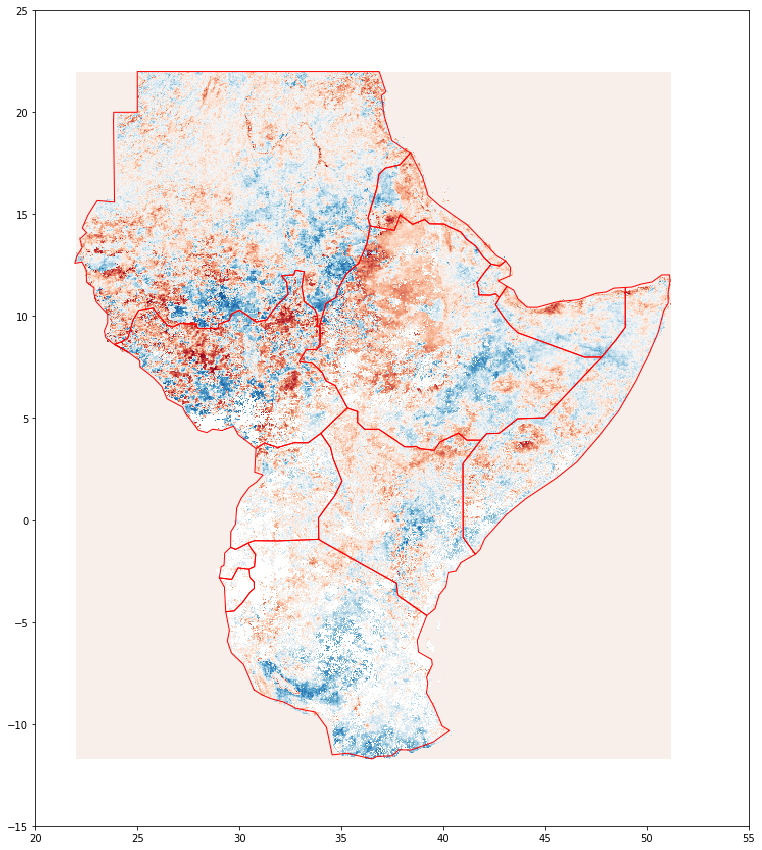

In [482]:
fig, ax = plt.subplots(figsize=(15,15))

show(ndvi_eastafrica_simplex_multi_ond, ax=ax, cmap = 'RdBu')
#show(ond_ndvi_uni, ax=ax, cmap = 'RdBu')


#zoom into East Africa
EastAfrica_basemap.plot(ax=ax, facecolor='none', edgecolor='red')
plt.axis([20, 55,-15,25])


In [ ]:
# raster_list = [temp_eastafrica_simplex_crop_tif, precip_eastafrica_simplex_crop_tif, ndvi_eastafrica_simplex_crop_tif]
# var_list = ['Temperature', 'Precipitation', 'NDVI']

# fig, axs = plt.subplots(1, 3, figsize = (30, 20))
# axs = axs.ravel()
# fig.subplots_adjust(wspace= 0.25, hspace = 0.35)
# fig = plt.gcf()
# for i, raster in enumerate(raster_list):
#     show(raster, ax=axs[i], cmap = 'Blues')
    
    
#     EastAfrica_basemap.plot(ax=axs[i], facecolor='none', edgecolor='darkblue', vmin = 0, vmax = 1)
    
#     axs[i].set_title(var_list[i], fontsize = 25)
    
# plt.savefig('/home/rgreen/ea_simplex_3panel.png', dpi = 300)

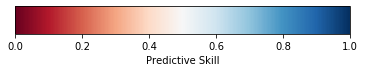

In [ ]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = mpl.cm.RdBu
norm = mpl.colors.Normalize(vmin=0, vmax=1)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=ax, orientation='horizontal', label='Predictive Skill')  

plt.savefig('/home/rgreen/colorbar_bugr', dpi = 300)

# 4. Embedding Dimension Spatial Sensitivity 
use Embed Dimension function

In [ ]:
embed_result = EmbedDimension(dataFrame = table, 
                                      lib = train, pred = test, columns = column, showPlot = False)
        max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
        print(max_embed)

In [ ]:
def pixelwise_embed_dimension(table, train, test, rs_rows, rs_cols):
    


    embed_max_df = []
    #table_chunk = table.loc[:100,500:510]
    
    for column in tqdm(table):
#         #print(column)
        if table[column].isnull().values.any():
            #print('null')
            embed_max_df.append(np.nan)
        else:
            interim_df = pd.DataFrame({'Time': list(range(0,522)), 'Data': table[column]}) #'Time': dekads
            embed_result = EmbedDimension(dataFrame = interim_df, 
                                      lib = train, pred = test, columns = 'Data', target = 'Data', showPlot = False)
            max_embed = embed_result.iloc[embed_result['rho'].idxmax()][0]
            
            #simplex_result = Simplex(dataFrame = interim_df, lib = train, pred = test, E = ed, Tp = pi, 
                                     #columns = 'Data', target = 'Data', showPlot = False)
#             error = ComputeError(list(simplex_result.Observations), list(simplex_result.Predictions))
#             MAE = list(error.values())[0]
#             RMSE = list(error.values())[1]
#             rho = list(error.values())[2]
           
            embed_max_df.append(max_embed) #adjust measure depending on output interest
            
    return(np.reshape(embed_max_df, (rs_rows,rs_cols)))
            

In [ ]:
ndvi_africa_ed = pixelwise_embed_dimension(ndvi_table, '1 100', '101 522', 800, 730)